<a href="https://colab.research.google.com/github/lilyzhizhou/datathon-3/blob/main/Logistic_Regression_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Import Pre-Diabetes Data
datapd = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #3/datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

print(datapd.shape)
datapd.head()

(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [ ]:
# Look for NA values
print(datapd.isnull().sum())

predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64


Determining Optimal Model parameters

---



In [12]:
# 1. Split the data into features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Imputation of missing values
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)
# Selected median bc it works well with skewed continuous data and is less sensitive to outliers and overfitting

# 4. Normalization of the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 5. Initialize a Logistic Regression model
model = LogisticRegression()

# Define a KFold cross-validation
cv = KFold(10)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 7


- the optimal number of features to include is 7
- we currently have 10 predictors

In [15]:
# which columns used and which wasn't
rfecv.support_

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True])

In [16]:
# features ranking low is better
rfecv.ranking_

array([1, 1, 1, 3, 1, 2, 1, 4, 1, 1])

Using Gridsearch to determine hyperparameters for logistic regression

---



In [17]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# 1. Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# 3. Use pipeline for gridsearchCV
std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()

pipe = Pipeline(steps=[('std_slc', std_slc),
 ('pca', pca),
  ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2','none']

parameters = dict(logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)

# 4. Run gridsearch
clf_GS = GridSearchCV(pipe, parameters, cv = cv)

clf_GS.fit(X_train, y_train)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(clf_GS.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
print(results[results['rank_test_score'] == 1])

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2         0.052332      0.002676         0.002546        0.001390   
5         0.055856      0.010427         0.002944        0.002813   
8         0.013617      0.000533         0.001910        0.000151   
11        0.028582      0.004741         0.002266        0.000975   
14        0.024728      0.008699         0.002028        0.000197   
..             ...           ...              ...             ...   
143       0.031006      0.003643         0.002828        0.001476   
145       0.022766      0.008635         0.003023        0.002008   
146       0.029304      0.004144         0.002347        0.001430   
148       0.015647      0.005550         0.002416        0.001644   
149       0.020943      0.007822         0.001876        0.000120   

    param_logistic_Reg__C param_logistic_Reg__penalty  \
2                  0.0001                        none   
5                0.000146                        none   


In [ ]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])

Best Penalty: none
Best C: 0.0001


- will use these parameters for final model

Final Model Building

---



In [18]:
# 1. Training logistic regression model
log_reg = LogisticRegression(penalty= 'none', C=0.0001, solver='lbfgs')
log_reg.fit(X_train, y_train)

# L2 regularization used as it will spread coefficient values more evenly across all predictors
# lbfgs used as for it's robustness

LogisticRegression(C=0.0001, penalty='none')

In [19]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, auc, acc, precision, recall, f1, class_report

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print("Confusion Matrix:")
    print(conf_matrix)
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)
    print("\nClassification Report:")
    print(class_report)

In [20]:
# 3.  Use the model to make predictions on the testing and training data
y_pred_test = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

# 4.  Evaluate the model
conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test = get_scores(y_pred_test, y_test)
conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')

print_scores(conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test)

======== Training Set ==========
Confusion Matrix:
[[2214 1109]
 [ 640  847]]
AUC :  0.6179343253932517
Accuracy :  0.6363825363825364

Precision:
0.4330265848670757

Recall:
0.5696032279757902

f1-score:
0.49201277955271566

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      3323
           1       0.43      0.57      0.49      1487

    accuracy                           0.64      4810
   macro avg       0.60      0.62      0.60      4810
weighted avg       0.67      0.64      0.65      4810

======== Test Set ==========
Confusion Matrix:
[[736 369]
 [208 291]]
AUC :  0.6246148405408102
Accuracy :  0.6402743142144638

Precision:
0.4409090909090909

Recall:
0.5831663326653307

f1-score:
0.5021570319240725

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1105
           1       0.44      0.58      0.50       499

    accuracy        

- since the goal is to identify pre-diabetics, we want the least false negatives
- prioritize recall
- recall for the the test model is 0.429 which is very low

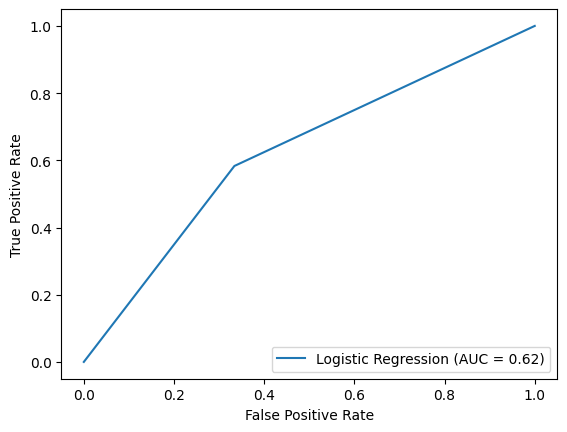

In [21]:
# Plot the ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_pred_test, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

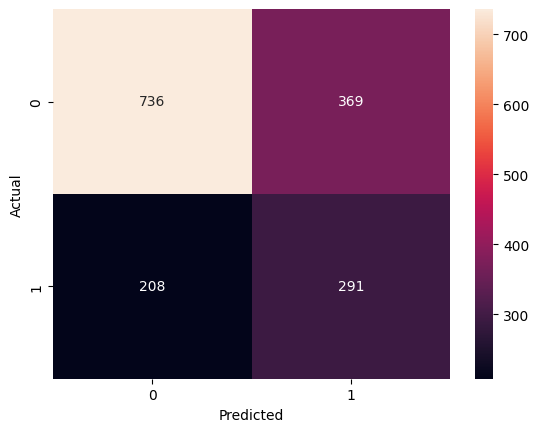

In [22]:
# Visualizing confusion matrix Test
sns.heatmap(conf_matrix_test, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
# Imputation of missing values
datapd['Total_Cholesterol'].fillna(datapd['Total_Cholesterol'].median(), inplace = True)

# Separate features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.624183
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  predm   No. Observations:                 6414
Model:                          Logit   Df Residuals:                     6403
Method:                           MLE   Df Model:                           10
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                 0.07675
Time:                        22:43:10   Log-Likelihood:                -4003.5
converged:                       True   LL-Null:                       -4336.3
Covariance Type:            nonrobust   LLR p-value:                1.514e-136
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.4477      0.261    -13.226      0.000      -3.959      -2.937
Age_at_E

variables that were significant:
- Age
- BMI
- Total_Cholesterol
- htnmed_bin

Considerations for future iterations: stratify by sex